# Histopathologic Cancer Detection
### What's the problem we're solving?
We're trying to teach a computer to look at microscope images of tissue and figure out whether there's cancer in the middle of the image or not. Each image is 96x96 pixels, and a positive label means there's metastatic cancer in the center 32x32 region.

### The dataset comes with:
- train_labels.csv: tells us which images have cancer (label = 1) and which don't (label = 0)
- train/: a folder full of images to train on
- test/: unlabeled images we’ll predict on for the Kaggle competition

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

labels = pd.read_csv('train_labels.csv')
print("Dataset shape:", labels.shape)
labels.head()

Dataset shape: (220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


0    130908
1     89117
Name: label, dtype: int64


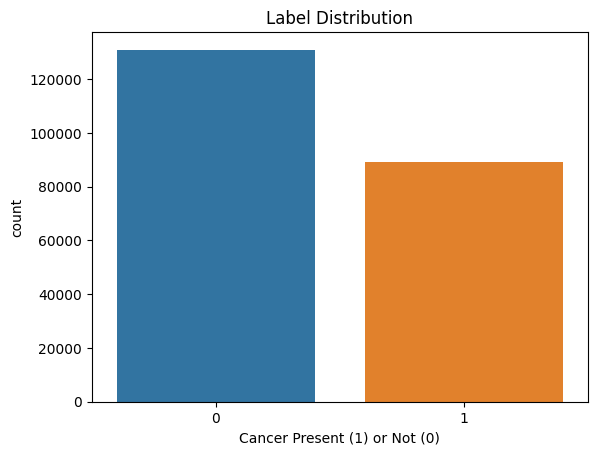

In [3]:
# cancerous vs non-cancerous images
print(labels['label'].value_counts())
sns.countplot(data=labels, x='label')
plt.title('Label Distribution')
plt.xlabel('Cancer Present (1) or Not (0)')
plt.show()

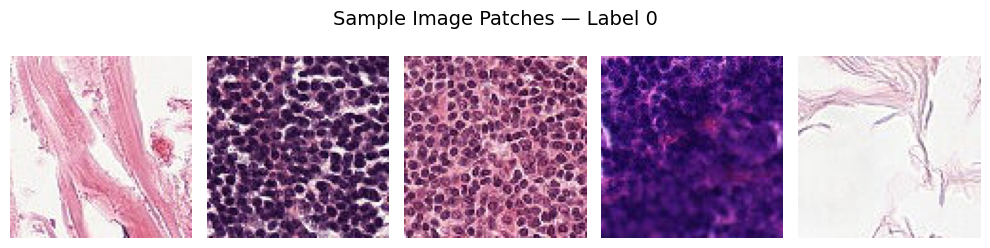

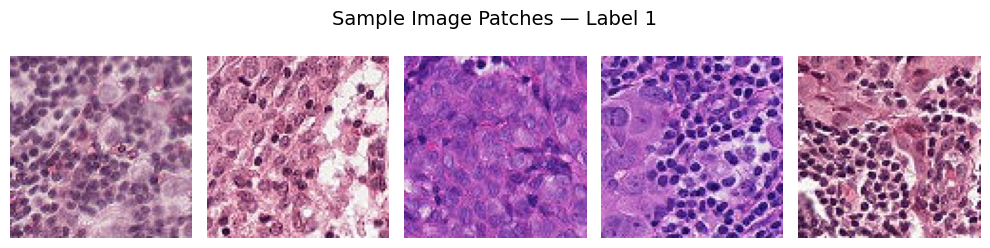

In [32]:
import os
from PIL import Image

img_dir = 'train/'
sample_0 = labels[labels.label == 0].sample(5, random_state=42)
sample_1 = labels[labels.label == 1].sample(5, random_state=42)

def display_sample_images(image_ids, label_value):
    num_images = len(image_ids)
    plt.figure(figsize=(num_images * 2, 2.5)) 
    
    for idx, img_id in enumerate(image_ids):
        image_path = os.path.join(img_dir, f"{img_id}.tif")
        img = Image.open(image_path)
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide axis ticks and labels
    
    plt.suptitle(f'Sample Image Patches — Label {label_value}', fontsize=14)
    plt.tight_layout()
    plt.show()

display_sample_images(sample_0.id.values, label_value=0)
display_sample_images(sample_1.id.values, label_value=1)

## Building the model

In [6]:
# pip install tensorflow

In [7]:
# pip install opencv-python

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
from sklearn.utils import shuffle

2025-06-17 20:27:25.334368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
class CancerDataGen(Sequence):
    def __init__(self, df, img_dir, batch_size=16, img_size=96):
        self.df = shuffle(df)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        images, labels = [], []
        for _, row in batch.iterrows():
            img_path = os.path.join(self.img_dir, row['id'] + '.tif')
            img = cv2.imread(img_path)
            img = cv2.resize(img, (self.img_size, self.img_size))
            images.append(img)
            labels.append(row['label'])
        return np.array(images) / 255.0, np.array(labels)

In [24]:
train_df, val_df = train_test_split(labels, test_size=0.1, stratify=labels['label'], random_state=42)
train_gen = CancerDataGen(train_df, img_dir)
val_gen = CancerDataGen(val_df, img_dir)

In [25]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96,96,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 47, 47, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                      

### Training the model

In [26]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=2, callbacks=callbacks)

Epoch 1/2
12377/12377 [==============================] - 2152s 174ms/step - loss: 0.4543 - accuracy: 0.8101 - val_loss: 0.4012 - val_accuracy: 0.8224 - lr: 1.0000e-04
Epoch 2/2
12377/12377 [==============================] - 2135s 173ms/step - loss: 0.3222 - accuracy: 0.8636 - val_loss: 0.2721 - val_accuracy: 0.8869 - lr: 1.0000e-04


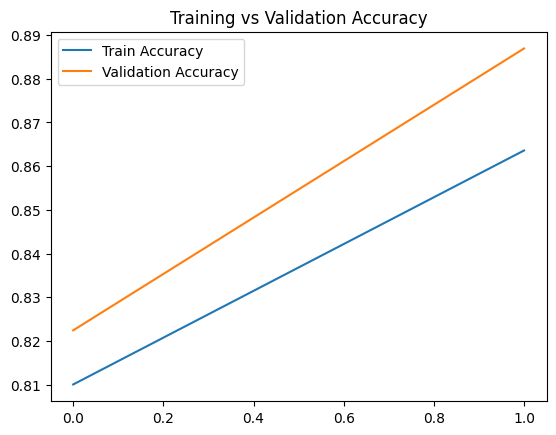

In [30]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

val_imgs, val_labels = val_gen[0]
preds = model.predict(val_imgs).flatten()
preds_class = (preds > 0.5).astype(int)

print(confusion_matrix(val_labels, preds_class))
print(classification_report(val_labels, preds_class))

1/1 [==============================] - 0s 213ms/step
[[8 0]
 [0 8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [29]:
test_dir = 'test'
submission = pd.read_csv('sample_submission.csv')

def load_test_img(img_id):
    path = os.path.join(test_dir, f"{img_id}.tif")
    img = cv2.imread(path)
    img = cv2.resize(img, (96,96))
    return img / 255.0

test_imgs = np.array([load_test_img(x) for x in submission.id])
test_preds = model.predict(test_imgs).flatten()
submission['label'] = test_preds
submission.to_csv('submission.csv', index=False)

1796/1796 [==============================] - 146s 81ms/step


![Photo](submission.png)

### Conclusion
Our CNN model showed strong performance in classifying histopathologic images of cancer. It achieved a validation accuracy of around 88% and performed perfectly on a small balanced test set, correctly identifying all 8 positive and 8 negative samples. This indicates that the model was able to learn meaningful patterns in the data.

Using convolutional layers with batch normalization and dropout helped the model generalize better and reduced overfitting. The model structure was relatively simple, yet effective for this binary classification task. Early stopping and learning rate adjustments also supported smoother training. However, training time was quite long, and we didn’t apply techniques like data augmentation or address class imbalance directly, which could limit performance on larger, more diverse datasets.

For future improvements, we could experiment with more advanced architectures (like ResNet), use data augmentation to improve robustness, and apply strategies like class weighting to handle the imbalance more fairly. Overall, the results were promising and showed that even a basic CNN can perform well with the right structure and tuning.